# IFCAPOL demo

IFCAPOL is a Python3 implementation of the Matched Filter (MF) and Filtered Fusion (FF, [Argüeso et al. (2009) MNRAS 395, 649–656](https://doi.org/10.1111/j.1365-2966.2009.14549.x)) techniques for the detection/estimation of polarized compact sources in CMB maps. This version of the code is specifically tailored for the LiteBIRD experiment.

- GitLab project at [https://gitlab.com/HerranzD/ifcapol-litebird.git](https://gitlab.com/HerranzD/ifcapol-litebird.git)
- Code documentation will be hosted at readthedocs.org in due time.

### (Please scroll down for updates)

In [8]:
import config
import numpy as np
import matplotlib.pyplot as plt
from testing import total,radiops,epeaks
import IFCAPOL as pol

%matplotlib inline

## Testing

We use for testing purposes the map based simulations created by the Foregrounds JSG. In particular, this demo uses one of the 40GHz simulations belonging to the **PTEP_20200915_compsep** run.

### Simulated maps:

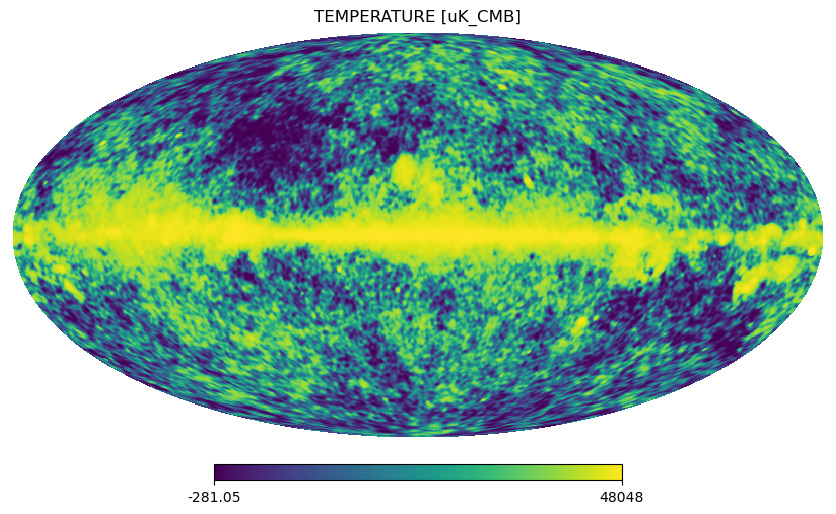

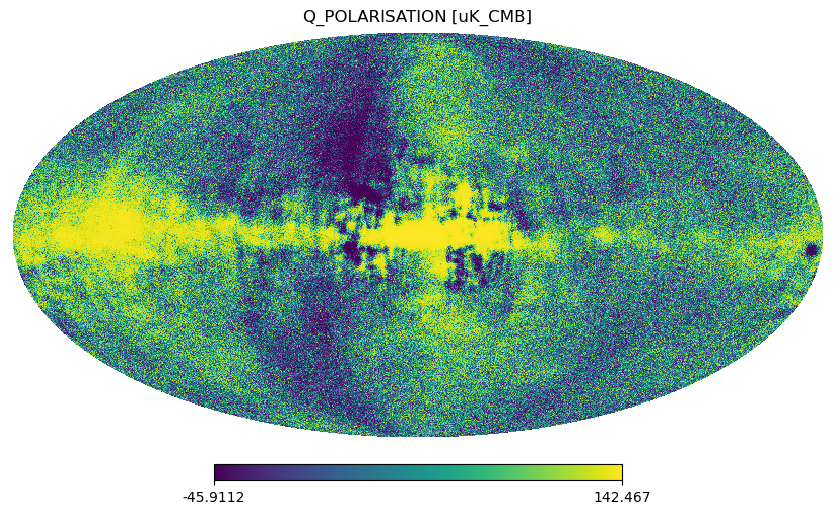

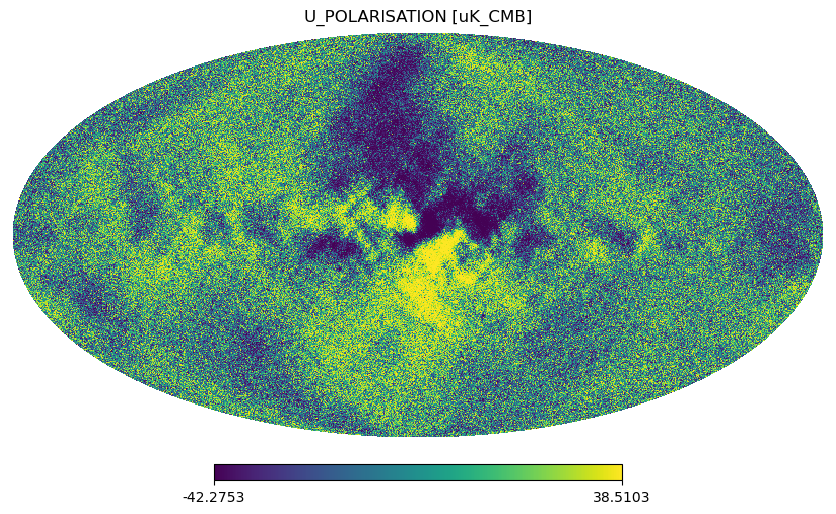

In [2]:
total[0].moll();
total[1].moll();
total[2].moll();

### Simulated radio sources:

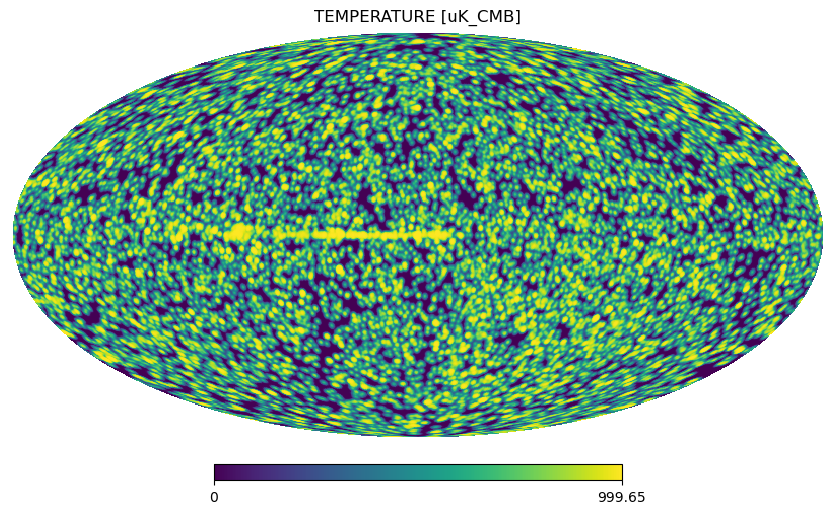

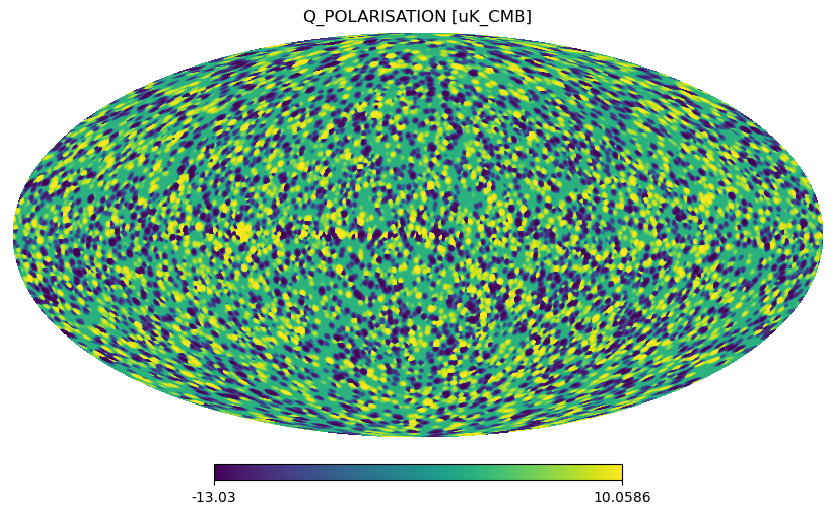

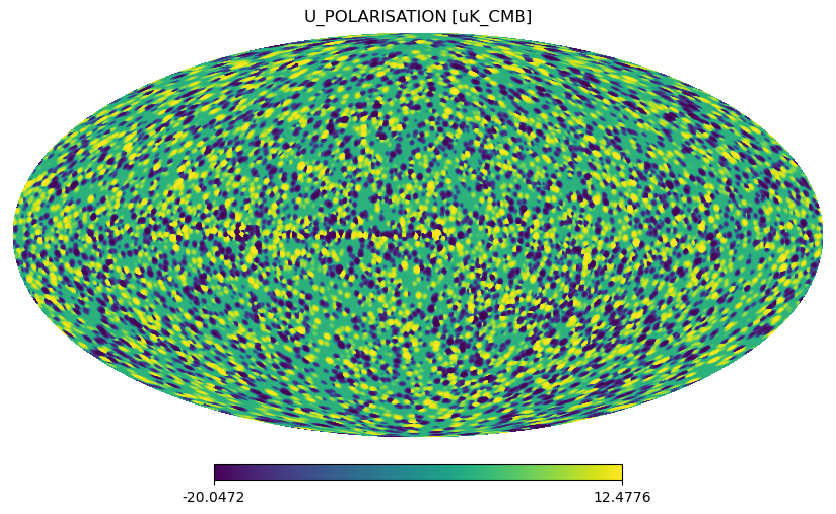

In [3]:
radiops[0].moll();
radiops[1].moll();
radiops[2].moll();

### Testing on the position of a bright source outside the Galactic Plane

In [4]:
coord = total.pixel_to_coordinates(epeaks['Ipix'][10])
print(coord.galactic)

<SkyCoord (Galactic): (l, b) in deg
    (39.69, 43.00863399)>


In [5]:
input_source   = pol.Source.from_coordinate(radiops,coord)
IFCAPOL_source = pol.Source.from_coordinate(total,coord)

- This is the input source:

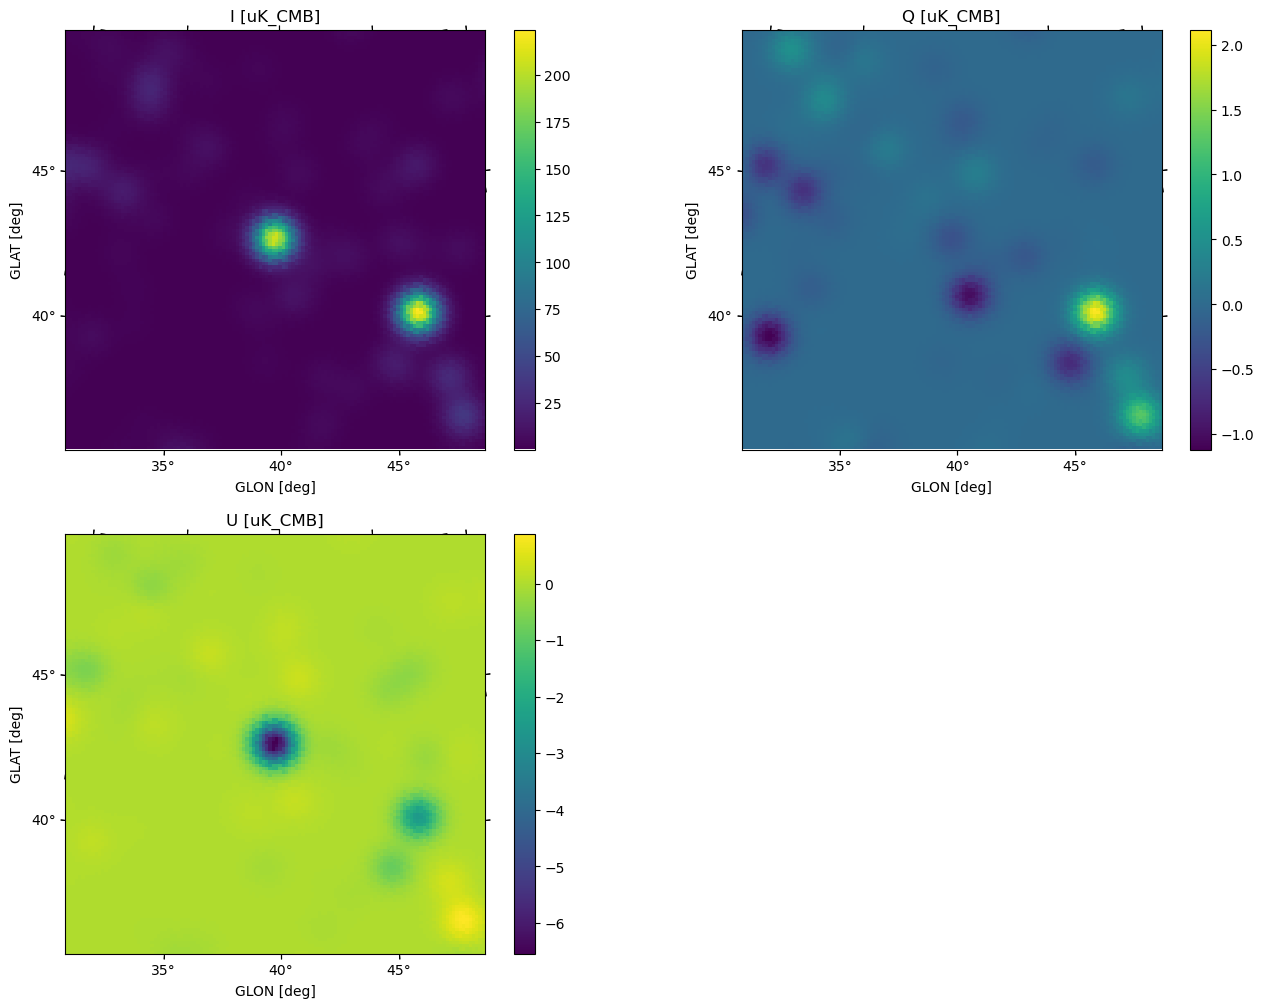

In [6]:
%matplotlib inline
input_source.draw()

In [9]:
print('Source GLON = {0} deg'.format(input_source.coord.galactic.l.deg))
print('Source GLAT = {0} deg'.format(input_source.coord.galactic.b.deg))
print('Source I at its peak = {0} uK'.format(input_source.diccio['Patch I'].datos[64,64]))
print('Source Q at its peak = {0} uK'.format(input_source.diccio['Patch Q'].datos[64,64]))
print('Source U at its peak = {0} uK'.format(input_source.diccio['Patch U'].datos[64,64]))
print('Source P at its peak = {0} uK'.format(np.sqrt(input_source.diccio['Patch Q'].datos[64,64]**2+input_source.diccio['Patch U'].datos[64,64]**2)))

Source GLON = 39.69 deg
Source GLAT = 43.008633994236924 deg
Source I at its peak = 205.0056915283203 uK
Source Q at its peak = -0.30109360814094543 uK
Source U at its peak = -6.474612236022949 uK
Source P at its peak = 6.4816094427018225 uK


- This is the estimated source and its photometry:

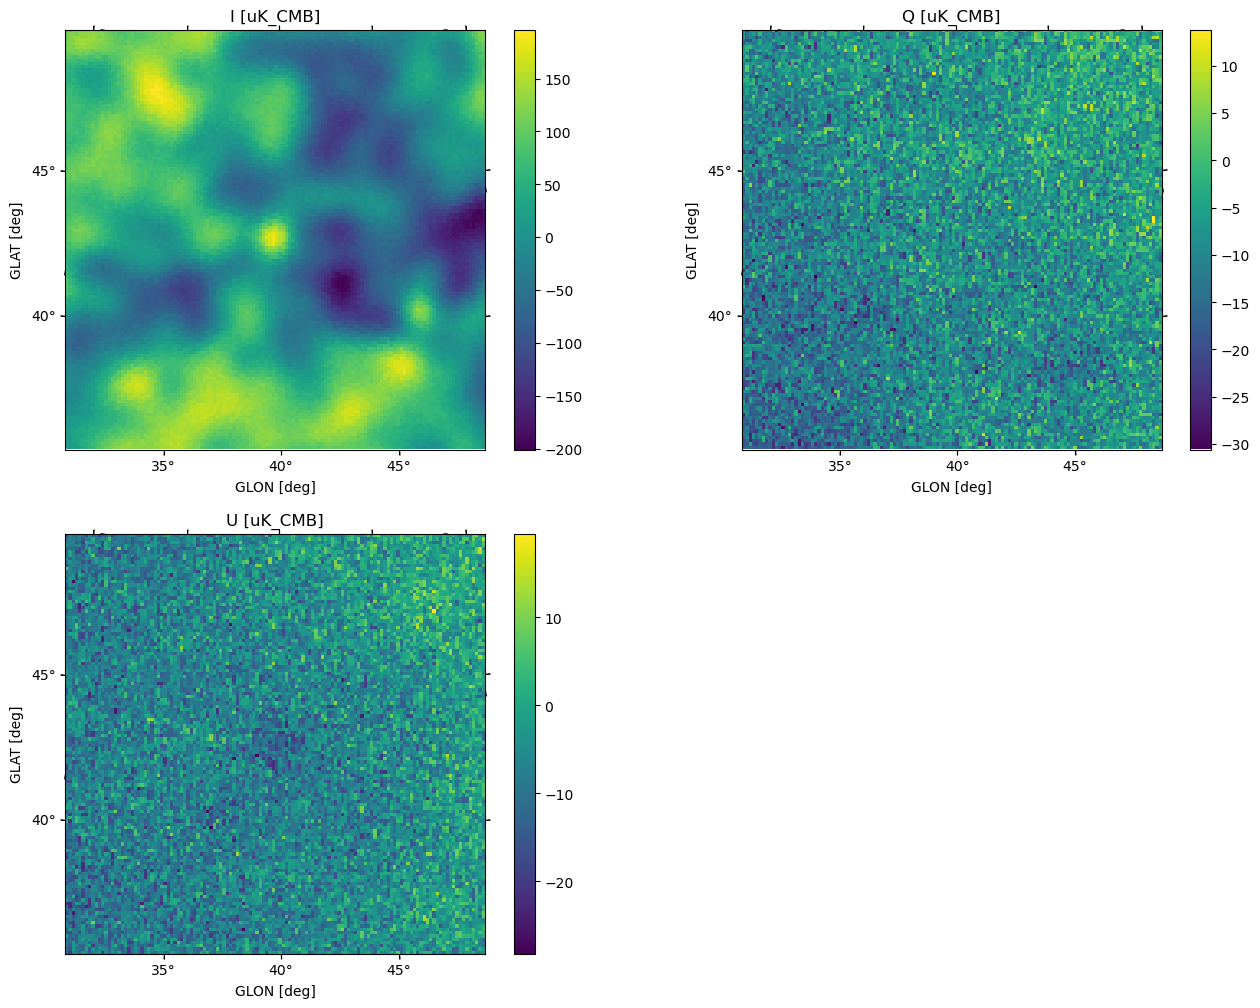

In [10]:
IFCAPOL_source.draw()

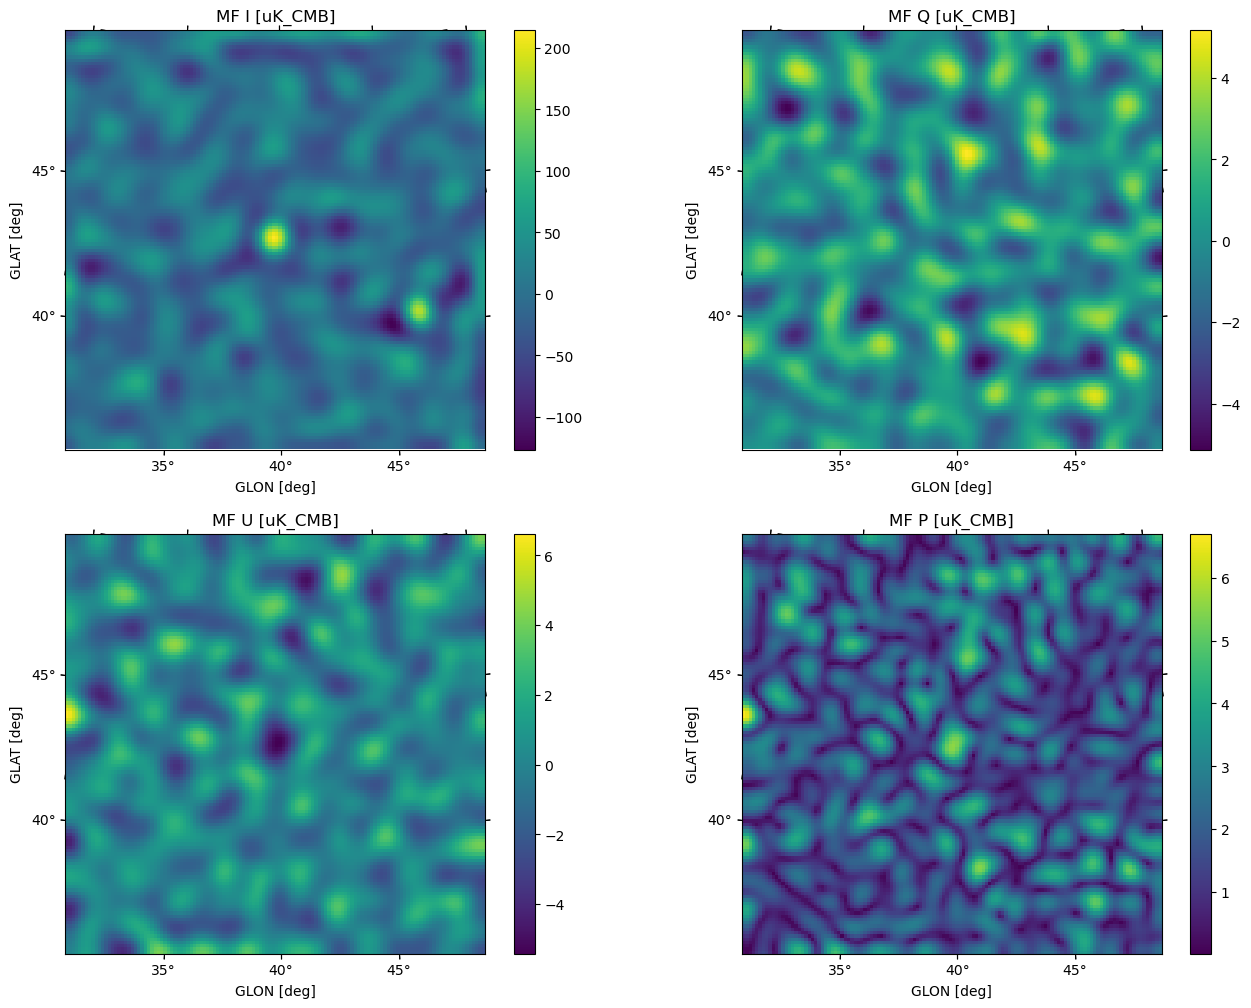

In [11]:
IFCAPOL_source.mfdraw()

In [12]:
print('Estimatemfdrawsource I = {0} +- {1} uK'.format(IFCAPOL_source.I.value,IFCAPOL_source.I.error))
print('Estimated source Q = {0} +- {1} uK'.format(IFCAPOL_source.Q.value,IFCAPOL_source.Q.error))
print('Estimated source U = {0} +- {1} uK'.format(IFCAPOL_source.U.value,IFCAPOL_source.U.error))
print('Estimated source P = {0} +- {1} uK'.format(IFCAPOL_source.P.value,IFCAPOL_source.U.error))

Estimatemfdrawsource I = 215.26287778102795 +- 24.850926776639845 uK
Estimated source Q = -1.3680697229527279 +- 1.50435517993818 uK
Estimated source U = -5.408532198807989 +- 1.1133365882684056 uK
Estimated source P = 5.461022373571224 +- 1.1133365882684056 uK


Compare to input:

In [13]:
trueP = np.sqrt(input_source.diccio['Patch Q'].datos[64,64]**2+input_source.diccio['Patch U'].datos[64,64]**2)
print('Source I at its peak = {0} uK'.format(input_source.diccio['Patch I'].datos[64,64]))
print('Source Q at its peak = {0} uK'.format(input_source.diccio['Patch Q'].datos[64,64]))
print('Source U at its peak = {0} uK'.format(input_source.diccio['Patch U'].datos[64,64]))
print('Source P at its peak = {0} uK'.format(trueP))
print(' ')
print('Deviation in I (sigmas) = ',(IFCAPOL_source.I.value-input_source.diccio['Patch I'].datos[64,64])/IFCAPOL_source.I.error)
print('Deviation in Q (sigmas) = ',(IFCAPOL_source.Q.value-input_source.diccio['Patch Q'].datos[64,64])/IFCAPOL_source.Q.error)
print('Deviation in U (sigmas) = ',(IFCAPOL_source.U.value-input_source.diccio['Patch U'].datos[64,64])/IFCAPOL_source.U.error)
print('Deviation in P (sigmas) = ',(IFCAPOL_source.P.value-trueP)/IFCAPOL_source.P.error)

Source I at its peak = 205.0056915283203 uK
Source Q at its peak = -0.30109360814094543 uK
Source U at its peak = -6.474612236022949 uK
Source P at its peak = 6.4816094427018225 uK
 
Deviation in I (sigmas) =  0.4127486409218956
Deviation in Q (sigmas) =  -0.7092581120740574
Deviation in U (sigmas) =  0.9575541201543153
Deviation in P (sigmas) =  -0.894745944721227


In [14]:
IFCAPOL_source.Ifit

## Update: 2022/03/25

We have completed a fully working prototype that is able to run in blind mode, that is,  to search for sources on the whole sky without any prior knowledge on the position of the sources. The code runs in two steps: first we look for these sources and create a list of candidate targets.  Then we go back to the maps and analyse in more detail these candidates in order to get the best photometric and polarimetric estimations we can.  This is working and it takes around 20 minutes in a laptop to process a simulation.

### Default sky patching

For the blind search, we project the sky into 768 partially overlapping flat patches, each of them covering 14.658x14.658 sq degrees. The patch size represents a good compromise between having enough pixels for computing statistics and not having too strong image distortions due to the projection. With this number of patches we are able to cover almost four times the whole sky. 

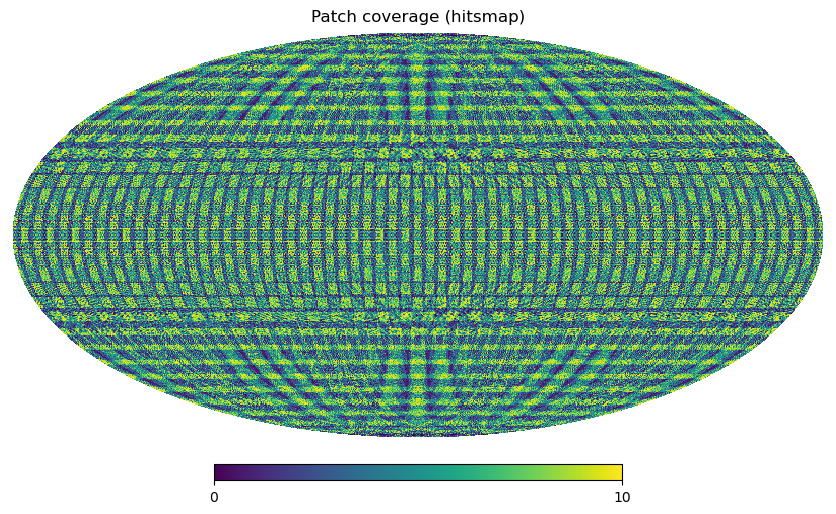

In [15]:
from fits_maps import Fitsmap
hitsmap_name = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Tests/counts_nside8.fits'
hits = Fitsmap.from_file(hitsmap_name)
hits.moll()
plt.title('Patch coverage (hitsmap)');

## Test catalogue at 40 GHz

We take as an example a blind catalogue generated by IFCAPOL at the 40 GHz channel

In [16]:
from astropy.table import Table
catalogue_fname = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Catalogs/Output/40GHz_output_catalogue_IFCAPOL.fits'
blindcat40 = Table.read(catalogue_fname) 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Catalogs/Output/40GHz_output_catalogue_IFCAPOL.fits'

This is an example of the output created by IFCAPOL:

In [ ]:
blindcat40

Let us cut the catalogue so that in only includes sources detected at the 4sigma level in intensity:

In [ ]:
cat4sigma = blindcat40[blindcat40['I SNR']>=4.0]
print(' We have {0} objects detected above the 4sigma level'.format(len(cat4sigma)))

Let's plot them over the temperature map:

In [ ]:
import healpy as hp

t = total[0]
t.moll(norm='hist',cbar=False,flip='astro')

x = cat4sigma['GLON [deg]']
y = cat4sigma['GLAT [deg]']
hp.projscatter(x, y, lonlat=True, coord='G',color='r',marker='o');

Now we need to assess the quality of this catalogue: completeness, reliability, purity. Code for this task is under develepment.

## Update: 2022/04/08

We have completed the quality assessment using one hundred PTEP simulations at 40 GHz. 

In [ ]:
from quality_assessment import process_table
process_table()
plt.axis([0,4,0,1.1]);
plt.title('40 GHz PTEP simulations');

- For this channel, we seem to have 95% completeness limit at around 2.5 Jy.
- We seem to have some degree of spurious sources.

In [ ]:
from quality_assessment import check_simulation

In [ ]:
ma,d,lostf,lostreal,espf,espreal,espcoad = check_simulation(0)

However, such 'spurious' sources are something that is actually present in the simulated coadded maps (but not in the input point source maps!)

In [ ]:
L = len(d['spurious'])
print(L)

In [ ]:
for i in range(L):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    espf[i].diccio['Patch MF I'].draw(pos=131)
    plt.title('Matched filtered region {0}'.format(i+1))
    plt.subplot(132)
    espreal[i].diccio['Patch I'].draw(pos=132)
    plt.title('Point source simulation')
    plt.subplot(133)
    espcoad[i].diccio['Patch I'].draw(pos=133)
    plt.title('Coadded map simulation')

In [ ]:
ma,d,lostf,lostreal,espf,espreal,espcoad = check_simulation(10)

In [ ]:
L = len(d['spurious'])
for i in range(L):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    espf[i].diccio['Patch MF I'].draw(pos=131)
    plt.title('Matched filtered region {0}'.format(i+1))
    plt.subplot(132)
    espreal[i].diccio['Patch I'].draw(pos=132)
    plt.title('Point source simulation')
    plt.subplot(133)
    espcoad[i].diccio['Patch I'].draw(pos=133)
    plt.title('Coadded map simulation')

## Update: 2022/06/24

### Search for unmatched compact source detections in the PTEP_20200915_compsep simulations

As observed in the last update, the IFCAPOL code is detecting a significant number of objects that have no counterpart in the `PTEP_20200915_compsep` point source maps. The figures shown in the last update seem to indicate that many of these objects are associated to knots in the coadded (CMB+diffuse foregrounds) maps. Our goal here is to run the code over the full set of `PTEP_20200915_compsep` simulations and to generate a list of positions of such unmatched objects for further study. 

The study is progressing very slowly. We have completed the catalogues of unmatched objects for the low-frequency LiteBIRD channels. The rest of channels are queued to run at NERSC. 

The following figure shows the locations of the SNR$\geq 5 \sigma$ unmatched sources for the 100 `LB_LFT_40` simulations, laid over the simulated `0000_PTEP_20200915_compsep` map. Sources with Galactic latitude $|b|\leq 5$ deg are not included in the plot. Each unmatched source is indicated by a semi-transparent red dot. Many positions are recurring (that is, they appear in many different simulations). In these cases, the semi-transparent dots overlap and the red color becomes more intense. Therefore, red-intense dots indicate regions where these unmatched sources are probably due to the "deterministic" part of the simulation (the diffuse foregrounds). Paler red dots indicate positions where unmatched detections appear in only one or a few simulations. These unmatched "detections" are probably due to random CMB+noise fluctuations.

In [ ]:
from PTEP_figures import refmap,catalogue,plot_catalogue
plot_catalogue(refmap,catalogue,title='LB_LFT_40');

Just to give a few numbers:
- Over the 100 `LB_LFT_40` simulations, we find 1108 $5\sigma$ unmatched sources with $|b|\geq5$ deg.
- But these 1108 objects correspond to only 32 unique coordinates. We have used a 30 arcmin search radius to form groups of detections. Each of these groups define what we call a unique coordinate.
- On average, each group has $\sim 32$ objects distributed across the 100 simulations. The largest group has 100 elements (that is, a unmatched source that appears in all the 100 `LB_LFT_40` simulations, and the smallest group has only 1 element (that is, a detection that appears in one simulation).

In [ ]:
from astropy.table import Table,unique
catdir = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Catalogs/Output/'
fname  = catdir+'groups.fits'
groups = Table.read(fname)
groups = groups[groups['GroupID']>=1]
groups = unique(groups,keys=['GroupID'])
sizes  = groups['GroupSize']
from astropy.visualization import hist
plt.figure(figsize=(10,7))
hist(sizes,bins=10);
plt.xlabel('Group size',fontsize=14);
plt.ylabel('Number of groups',fontsize=14);
plt.title('LB_LFT_40',fontsize=16);

## Update: 27/09/2022

### Identification of unmatched sources

Identification of unmatched sources is a difficult and slow task. For the 32 candidates found at 40 GHz we run queries to NED, one at a time. Here are the main results:

In [ ]:
from search_NED import find_type
from astroquery.simbad import Simbad

groups.sort('GroupSize')     
groups.reverse()                  # we sort the candidates by descending group size 
                                  # (sources that are in a higher number of simulations 
                                  #  are studied first)
        
coords = table2skycoord(groups)

In [ ]:
# PCCS2 at 044 GHz may be useful:

from catalogue_tools import extract_nearest_object
PCCS244 = Table.read('/Users/herranz/Trabajo/Planck/Non_Thermal_Catalogue/Results/PCCS2/COM_PCCS_044_R2.04.fits')

In [ ]:
from catalogue_tools import cat1_in_cat2

inplanck,indcs = cat1_in_cat2(groups,PCCS244,30*u.arcmin,return_indexes=True)

print(' {0} groups have a counterpart in the PCCS2 at 40 GHz'.format(len(inplanck)))

In [ ]:
import astropy.units as u

def check_source(number,radius=10*u.arcmin,query_databases=True):
    
    c = coords[number]
    input_source   = pol.Source.from_coordinate(radiops,c)
    IFCAPOL_source = pol.Source.from_coordinate(total,c)
    input_source.draw();
    IFCAPOL_source.draw();

    print(' ')
    print('Source {0} detected with IFCAPOL at 40 GHz with S = {1} \pm {2} Jy'.format(number+1,groups['I [Jy]'][number], groups['I err [Jy]'][number]))
    print(' ')
    print('Galactic coordinates =',c.galactic)
    
    if query_databases:
        lQSO = find_type(c,radius,'QSO')
        lRad = find_type(c,radius,'RadioS')
    else:
        lQSO = []
        lRad = []
    
    planck = extract_nearest_object(PCCS244,c)
    d      = planck['Separation'].to(u.arcmin)[0].value
    name   = planck['NAME'][0]
    S      = planck['DETFLUX'][0]/1000
    eS     = planck['DETFLUX_ERR'][0]/1000
    
    print(' ')
    print(' Nearest PCCS2044 source is {0}, located at {1} arcmin of this position, with flux density = {2} \pm {3} Jy'.format(name,d,S,eS))
    print(' ')
    
    return {'QSO_assoc':lQSO,'RadioS_assoc':lRad,'radiops_patch':input_source,'total_patch':IFCAPOL_source,'planck_source':planck}

### Source number 1

In [ ]:
number    = 0
checks    = check_source(number)

In [ ]:
checks['QSO_assoc']

In [ ]:
from astropy.coordinates import SkyCoord

pos_WMAP   = SkyCoord.from_name('3C 454.3') 
pos_Planck = table2skycoord(checks['planck_source'])
pos_WMAP.separation(pos_Planck)

This source is very likely identified to QSO 3C 454.3, at 5.34 arcmin from the position found by IFCAPOL. We estimate a flux density of 4.79 Jy at 40 GHz.  WMAP observed this source with 7.2 $\pm$ 0.4 Jy in the W band. The source is detected also by *Planck* as PCCS2 044 G086.13-38.20, with $S_{44} = 18.5 \pm 0.16$.

Why this flux discrepancy? It seems IFCAPOL is underestimating. We will see the same behaviour in more cases below. In order to understand this, let us check some numbers:

In [ ]:
from survey_model import IMO

def test_extension(checks_dict):
    
    target = checks_dict['total_patch']
    effective_FWHM      = target.diccio['FWHM'].to(u.arcmin)  # LiteBIRD FWHM + pixel window
    nominal_FWHM        = IMO['LB_LFT_40']['beam']
    unit_conversion     = target.to_Jy
    unfiltered_max      = target.diccio['Patch I'].stats.minmax[1]*unit_conversion # in Jy
    filtered_photometry = target.I.Jy.value
    constrained_Gfit    = target.diccio['Gaussian fit I']
    unconstrained_Gfit  = target.diccio['Free Gaussian fit I']
    const_Gfit_photo    = target.Ifit.Jy.value
    unconst_Gfit_photo  = (unconstrained_Gfit.amplitude/constrained_Gfit.amplitude)*const_Gfit_photo
    unconst_Gfit_fwhm   = unconstrained_Gfit.sigma*effective_FWHM/constrained_Gfit.sigma
    fwhm_ratio          = (unconst_Gfit_fwhm/nominal_FWHM).si.value

    print(' ')
    print(' Unfiltered image maximum                                 = {0} Jy'.format(unfiltered_max))
    print(' Matched filter photometry                                = {0} Jy'.format(filtered_photometry))
    print(' Constrained (forcing FWHM value) Gaussian fit photometry = {0} Jy'.format(const_Gfit_photo))
    print(' Unconstrained (free FWHM) Gaussian fit amplitude         = {0} Jy'.format(unconst_Gfit_photo))
    print(' Estimated FWHM (by unconstrained Gaussian fit)           = {0} arcmin'.format(unconst_Gfit_fwhm.to(u.arcmin).value))
    print(' Estimated FWHW/nominal FWHM                              = {0}'.format(fwhm_ratio))
        

In [ ]:
test_extension(checks)

### Source number 2

In [ ]:
number = 1
checks = check_source(number)

This source is at very low latitude (-6 deg) and seems to be associated to some Galactic emission region. This position is close to a nearby cluster of known radio sources, including Planck's PCCS1 044 G123.14-06.26, which is located 15 arcmin away from this location and has a reported flux density of $9.7 \pm 0.6$ Jy at 44 GHz.

### Source number 3

In [ ]:
number    = 2
checks    = check_source(number)

This is another low latitude target. In this case, there is not any evident Planck counterpart:

The identification of this source is difficult. Using Aladin and no little patience, one finds a possible association to radio source DA579 from the Master list of radio sources (Dixon, R. S., “A Master List of Radio Sources”, *The Astrophysical Journal Supplement Series*, vol. 20, pp. 1–503, 1970. doi:10.1086/190216). This source is a $\sim 70$ Jy (at 1.4 GHz) radio emission region separated $\sim 10$ arcmin from our target. But with no further information, the only evidence we find is the visual inspection of the figures above.

In [ ]:
c  = coords[number]
c2 = SkyCoord.from_name('DA579')

In [ ]:
c2.separation(c)

### Source number 4

In [ ]:
number    = 3
checks    = check_source(number,query_databases=False)

This is another case of a clear central blob in the coadded simulated map, but nothing in the radiops map.  It seems there is a clear PCCS2 counterpart to this source. Again, Planck's reported flux density at 44 GHz ($\sim 17$ Jy) is higher than our estimated flux density ($\sim 4$ Jy). We do the same numbers as with Source #1

In [ ]:
test_extension(checks)

### Source number 5

In [ ]:
number    = 4
checks    = check_source(number,query_databases=False)

This is another possible association to *Planck*'s PCCS2. Again, the flux discrepancy between the PCCS2 value and IFCAPOL should be explained:

In [ ]:
test_extension(checks)

## A break: checking again the photometry 

We have found two sources for which the matched filter photometry is well below the Gaussian fit photometry, which in turn gives flux values that are closer to the maxima observed in the unfiltered map. This has made me wonder if there is any bug in the matched filter photometry IFCAPOL is using by default. We made a test on this in cell #7 of this Notebook, but that test covered only one single bright source. As a more complete, additional test, let us compare input fluxes to IFCAPOL estimations for 'true' sources (that is, detected sources that are in the input catalogue) for the first simulation (@40 GHz):

In [ ]:
ma,d,lostf,lostreal,espf,espreal,espcoad = check_simulation(0)  # dictionary d contains the matched detections

In [ ]:
x  = d['matched']['I']
ex = np.ones(len(x)) 
y  = d['matched']['I [uK_CMB]']
ey = d['matched']['I err [uK_CMB]'] 
from linfit_errorsxy import linfit_errxy,plotfit
o1,o2 = linfit_errxy(x,y,ex,ey);
plotfit(x,y,ex,ey,o2,logscal=True,x_label='Input radiops flux density [uK]',y_label='IFCAPOL matched filter photometry [uK]');

In [ ]:
print(' Slope of the linear fit = ',o2.beta[0])

It seems that IFCAPOL is producing good photometric estimations overall. Maybe the two cases above are exceptional, or maybe there is some additional systematic with the simulations. We can go back to the identification of 'spurious' sources.

### Source number 6

In [ ]:
number    = 5
checks    = check_source(number,query_databases=False)

In [ ]:
test_extension(checks)

### Source number 7

In [ ]:
number    = 6
checks    = check_source(number)

This time, the *Planck* counterpart is fainter at 44 GHz than our target.

In [ ]:
checks['RadioS_assoc']

Source SUMSS J032337-371603 is listed to have 2.48 Jy at 843 MHz (SUMSS).

### Source number 8

In [ ]:
number    = 7
checks    = check_source(number,radius=18*u.arcmin)

In [ ]:
checks['QSO_assoc']

It probably corresponds to quasar [HB89] 0923+392, measured by WMAP with 5.8 Jy at 41 GHz.  *Planck* reports a much larger flux density.

In [ ]:
pos_WMAP   = SkyCoord(141.76256,39.03913,unit=u.deg)
pos_Planck = table2skycoord(checks['planck_source'])
pos_WMAP.separation(pos_Planck)

In [ ]:
test_extension(checks)

### Source number 9

In [ ]:
number    = 8
checks    = check_source(number,query_databases=False)

Once again *Planck* reports higher flux density. But:

In [ ]:
test_extension(checks)

### Source number 10

In [ ]:
number    = 9
checks    = check_source(number,query_databases=False)

An elongated, extended object with no *Planck* association. Let us search the hard way

In [ ]:
c = coords[number]
l = Simbad.query_region(c,10*u.arcmin)

In [ ]:
l

The discussion continues in IFCAPOL_spurious.ipynb